### Running the setup module

In [1]:
! cd BIG_DATA_CHALLENGE_TEAM_46
import textProcessPipeline as txt
txt.import_modules()
! cd Twitter_Sentiment_Analysis-master
! pip install mysql-connector-python
! pip install python-dotenv
! pip install pandas
! pip install dask

The system cannot find the path specified.
  0%|          | 0/9 [00:00<?, ?it/s]

Importing inflect
Importing contractions
Importing plotly
Importing emoji
Importing emot
Importing pandas


 67%|██████▋   | 6/9 [00:00<00:00,  8.77it/s]

Importing seaborn


 78%|███████▊  | 7/9 [00:01<00:00,  3.37it/s]

Importing matplotlib
Importing nltk


100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wilson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wilson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wilson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
The system cannot find the path specified.


### Read from mysql database using dask

In [121]:
import dask.dataframe as dd
import pandas as pd
host='localhost'
user='root'
password=os.getenv('PASSWORD1')
database='BigData'
tweets_df = dd.read_sql_table('temp', f'mysql+pymysql://{user}:{password}@{host}:3306/BigData', index_col='Tweet_ID', npartitions=15)

### Data Cleaning -> Drop columns and separte datetime

In [122]:
tweets_df = tweets_df.drop(columns=['Logits_Neutral','Logits_Positive','Logits_Negative'])
tweets_df['Created_at']=tweets_df['Created_at'].map_partitions(lambda df: pd.to_datetime(df, utc=True), meta=('Created_at', 'datetime64[ns]')).compute()
tweets_df['Day'] = tweets_df['Created_at'].dt.day
tweets_df['Hour'] = tweets_df['Created_at'].dt.hour
tweets_df['Minute'] = tweets_df['Created_at'].dt.minute
tweets_df['time'] = tweets_df['Created_at'].map_partitions(lambda df: df.map(lambda x: x.strftime('%M-%D %H:%M')), meta=pd.Series([], dtype='datetime64[ns]', name='time'))

### Data Cleaning -> Clean up text create new text column 'Tweets_Clean'

In [93]:
from nltk.corpus import stopwords
stopwords_full = list(stopwords.words('english'))
commonTwitterStopwords = ['rts','quot', 'sxsw','httpstcoym8csuf43x','rt', 'RT', 'retweet', 'new', 'via', 'us', 'u', 'covid', 'coronavirus', '2019', 'coronavírus',
                          '#coronavirus', '19', '#covid', '#covid19','#covid2019', '…', '...', '“', '”', '‘', '’']
stopwords_full.extend(commonTwitterStopwords)
num_list = '0123456789'
freq = pd.Series(tweets_df['Content']).value_counts()
less_freq = list(freq[freq ==1].index)
tweets_df['Tweets_Clean']= tweets_df['Content'].map_partitions(lambda df: df.map(lambda x: txt.text_process_pipe(x, stopwords_full, num_list, less_freq)), meta=pd.Series([], dtype=object, name='Tweets_Clean')).compute()

### -> to csv file

In [ ]:
tweets_df.to_csv('cleaned_tweets_df.csv', single_file=True)


In [124]:
# GB=tweets_df.groupby(['Minute','Day','Hour']).count().compute()
# GB['Tweets_Clean']
GB['id']
# GB.group.keys()
# GB.columns

time
00-08/01/20 00:00    183
04-08/01/20 00:04      1
14-08/01/20 00:14      1
10-08/01/20 09:10      1
12-08/01/20 09:12      1
14-08/01/20 09:14      1
16-08/01/20 09:16      1
26-08/01/20 09:26      2
32-08/01/20 09:32      1
33-08/01/20 09:33      1
37-08/01/20 09:37      1
41-08/01/20 09:41      1
49-08/01/20 09:49      1
54-08/01/20 09:54      1
55-08/01/20 09:55      1
56-08/01/20 09:56      1
57-08/01/20 09:57      1
Name: id, dtype: int64

In [126]:
tweets_df.columns

Index(['id', 'Sentiment_Label', 'Created_at', 'location', 'followers_count',
       'Original_tweet', 'User_id', 'Content', 'Retweet_count', 'Tweet_ID__1',
       'Day', 'Hour', 'Minute', 'time'],
      dtype='object')

AttributeError: 'DataFrame' object has no attribute 'get'

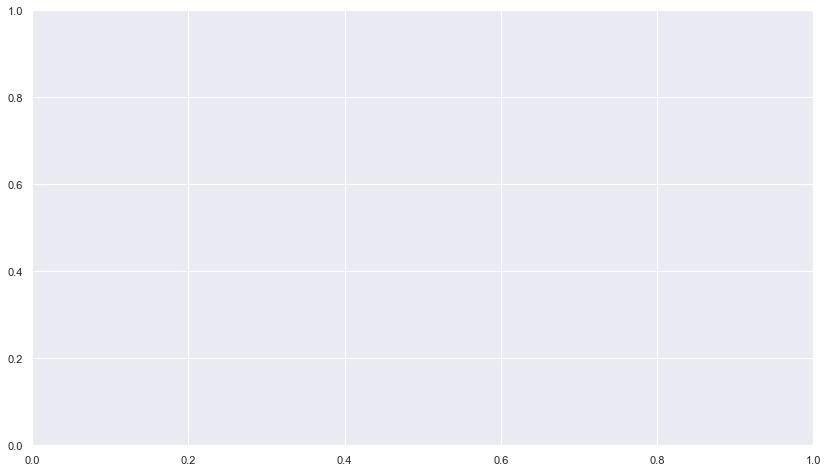

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
# GB=tweets_df.groupby(['time', 'Sentiment_Label']).count().unstack('Sentiment_Label').compute()
fig, ax = plt.subplots(figsize=(14, 8))
# GB.plot.bar(ax=ax)
sns.barplot(x='time', hue='Sentiment_Label', ax=ax, data=tweets_df)
# GB=tweets_df.groupby(['time']).count().compute()
# bar_plot = sns.barplot(x='time' ,y='Tweets_Clean', data=GB)
plt.title('Number of Tweets per Month', fontweight='bold')
plt.grid(True, alpha=0.1, c='black')
plt.ylabel('Tweet Count')
plt.xlabel('Months/Year')
plt.show()


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 8))
GB=tweets_df.groupby(['Minute','Day','Hour']).count().compute()
bar_plot = sns.barplot(x='Month', y='Tweets_Clean', data=GB)
for p in bar_plot.patches:
             bar_plot.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 6), textcoords='offset points')
plt.title('Number of Tweets per Month', fontweight='bold')
plt.grid(True, alpha=0.1, c='black')
plt.ylabel('Tweet Count')
plt.xlabel('Months/Year')
plt.show()
plt.savefig('tweet_count_trend.png')

sns.countplot(x = 'Month', hue='Sentiment_Label', 
            palette = 'GnBu',
            data=tweets_df)
plt.title('Setiments over time', fontweight='bold')
plt.show()
plt.savefig('sentiment_trend.png')


from sentiment_class import TwitterSentiment, month_as_string

tweets_all_months = TwitterSentiment(input_df=tweets_df, tweet_column='Tweets_Clean')
tweets_all_months.plot_most_common_words(n_most_common=15, figsize=(10, 8))
tweets_all_months.plot_wordcloud(figsize=(10, 8))
                                                       
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(4,4)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words2 = get_top_n_bigram(tweets_df['Tweets_Clean'], 20)
df2 = pd.DataFrame(common_words2,columns=['Tweet', "Count"])
df2.head()

df2.groupby('Tweet').sum()['Count'].sort_values().plot(
    kind='barh',
    figsize=(12,6),
    xlabel = "4-gram Words",
    colormap='Accent'
)
plt.title('20 Most Frequently Occuring 4-grams')
plt.ylabel('4-gram')
plt.xlabel('# of Occurrences')
plt.savefig('4gram.png')
plt.show()
plt.close()
                                                       
my_colors = ['red', 'orange', 'green'] 
df['Sentiment_Label'].value_counts().plot(kind='bar',color=my_colors)
plt.title('Tweet sentiments')
plt.ylabel('Counts')
plt.xlabel('Emotion')
plt.show()
plt.savefig('sentiment_bar.png')



ValueError: Could not interpret input 'Month'

<Figure size 1008x576 with 0 Axes>

In [117]:
# pip install lexicalrichness
# pip install textblob
# pip install textstat

from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))

from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
# nltk.download('averaged_perceptron_tagger')

tweets_df.loc[tweets_df['Sentiment_Label'] == 'positive', ['label']] = 'POSITIVE'
tweets_df.loc[tweets_df['Sentiment_Label'] == 'negative', ['label']] = 'NEGATIVE'
tweets_df.loc[tweets_df['Sentiment_Label'] == 'neutral', ['label']] = 'NEUTRAL'
tweets_df

tweets_df['text_num_uppercase'] = tweets_df['Content'].str.count(r'[A-Z]')
tweets_df['text_len'] = tweets_df['Content'].str.len()
tweets_df['text_pct_uppercase'] = tweets_df.text_num_uppercase.div(tweets_df.text_len)

x1 = tweets_df.loc[tweets_df['label']=='POSITIVE']['text_num_uppercase']
x2 = tweets_df.loc[tweets_df['label']=='NEGATIVE']['text_num_uppercase']
x3 = tweets_df.loc[tweets_df['label']=='NEUTRAL']['text_num_uppercase']
group_labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)','rgb(0, 300, 300)']

fig = ff.create_distplot(
    [x1, x2, x3], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Uppercase in tweets', template="plotly_white")
fig.show()

fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='POSITIVE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'NEGATIVE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'NEUTRAL',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Capital Letter in tweets', template="plotly_white")
fig.show()


tweets_df['text_num_stop_words'] = tweets_df['Content'].str.split().apply(lambda x: len(set(x) & stop_words))
tweets_df['text_word_count'] = tweets_df['Content'].apply(lambda x: len(str(x).split()))
tweets_df['text_pct_stop_words'] = tweets_df['text_num_stop_words'] / tweets_df['text_word_count']

x1 = tweets_df.loc[tweets_df['label']=='POSITIVE']['text_num_stop_words']
x2 = tweets_df.loc[tweets_df['label']=='NEGATIVE']['text_num_stop_words']
x3 = tweets_df.loc[tweets_df['label']=='NEUTRAL']['text_num_stop_words']
group_labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)','rgb(0, 300, 300)']

fig = ff.create_distplot(
    [x1, x2, x3], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Stop Words in tweets', template="plotly_white")
fig.show()

fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='POSITIVE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'NEGATIVE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'NEUTRAL',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Stop Words in tweets', template="plotly_white")
fig.show()

df=tweets_df

df['token'] = df.apply(lambda row: nltk.word_tokenize(row['Content']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())
df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)
df['NNP']

df = df[['Content','label', 'text_pct_uppercase', 'text_pct_stop_words', 'NNP']].rename(columns={'NNP': 'NNP_title'})

x1 = df.loc[df['label']=='POSITIVE']['NNP_title']
x2 = df.loc[df['label'] == 'NEGATIVE']['NNP_title']
x3 = df.loc[df['label'] == 'NEUTRAL']['NNP_title']

group_labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)','rgb(0, 300, 300)']

fig = ff.create_distplot(
    [x1, x2, x3], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper nouns in tweets', template="plotly_white")
fig.show()

fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='POSITIVE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'NEGATIVE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'NEUTRAL',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Proper nouns in tweets', template="plotly_white")
fig.show()

readability_score = []
for doc in df['Content']:
    readability_score.append(textstat.dale_chall_readability_score(doc))
    
df['dale_chall_readability_score'] = readability_score

x1 = df.loc[df['label']=='POSITIVE']['dale_chall_readability_score']
x2 = df.loc[df['label'] == 'NEGATIVE']['dale_chall_readability_score']
x3 = df.loc[df['label'] == 'NEUTRAL']['dale_chall_readability_score']

group_labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)','rgb(0, 300, 300)']

fig = ff.create_distplot(
    [x1, x2, x3], group_labels,colors=colors)

fig.update_layout(title_text='Readability score of tweets', template="plotly_white")
fig.show()

fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='POSITIVE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'NEGATIVE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'NEUTRAL',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Readability score of tweets', template="plotly_white")
fig.show()

ttr = []
for doc in df['Content']:
    lex = LexicalRichness(doc)
    ttr.append(lex.ttr)

df['ttr'] = ttr

x1 = df.loc[df['label']=='POSITIVE']['ttr']
x2 = df.loc[df['label'] == 'NEGATIVE']['ttr']
x3 = df.loc[df['label'] == 'NEUTRAL']['ttr']

group_labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)','rgb(0, 300, 300)']

fig = ff.create_distplot(
    [x1, x2, x3], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in tweets', template="plotly_white")
fig.show()

fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='POSITIVE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'NEGATIVE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'NEUTRAL',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Type-token ratio in tweets', template="plotly_white")
fig.show()





In [4]:
# text = " ".join(review for review in tweets_df.Tweets_Clean)
# text
# %pip install tensorflow

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split 
from sklearn.ensemble import RandomForestRegressor 
import numpy as np
from sklearn.svm import LinearSVC
from scipy.stats import reciprocal, uniform


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

# tweets_df=pd.read_csv('cleaned_tweets_df.csv')
df_model=tweets_df
df_model
X = df_model['Tweets_Clean'] 
y = df_model['Sentiment_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,
                                                    random_state=42)
X_train
# Vectorizing
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))

X_train_vec = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test).toarray()


Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.75      0.89      0.81      1105
     neutral       0.78      0.79      0.79      1053
    positive       0.99      0.33      0.50       342

    accuracy                           0.77      2500
   macro avg       0.84      0.67      0.70      2500
weighted avg       0.79      0.77      0.76      2500

Accuracy score MultinomialNB()= 0.77


confusion matrix


[[980 125   0]
 [217 835   1]
 [118 110 114]]




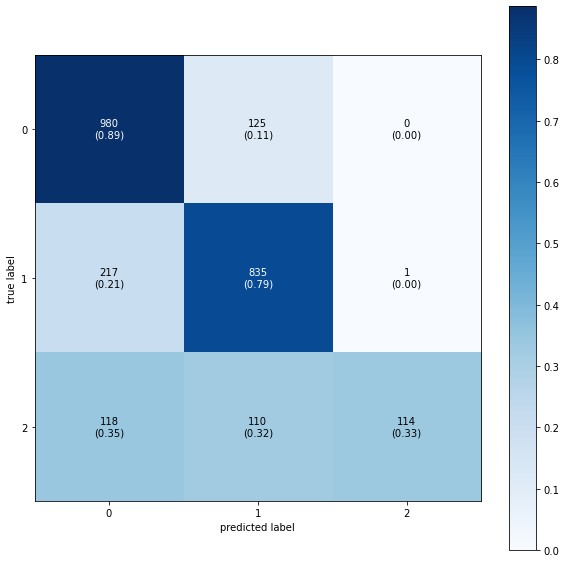

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.87      0.77      0.82      1105
     neutral       0.75      0.88      0.81      1053
    positive       0.79      0.67      0.72       342

    accuracy                           0.80      2500
   macro avg       0.81      0.77      0.79      2500
weighted avg       0.81      0.80      0.80      2500

Accuracy score RandomForestClassifier(class_weight='balanced', n_jobs=6, random_state=0)= 0.80


confusion matrix


[[854 220  31]
 [ 98 927  28]
 [ 30  84 228]]




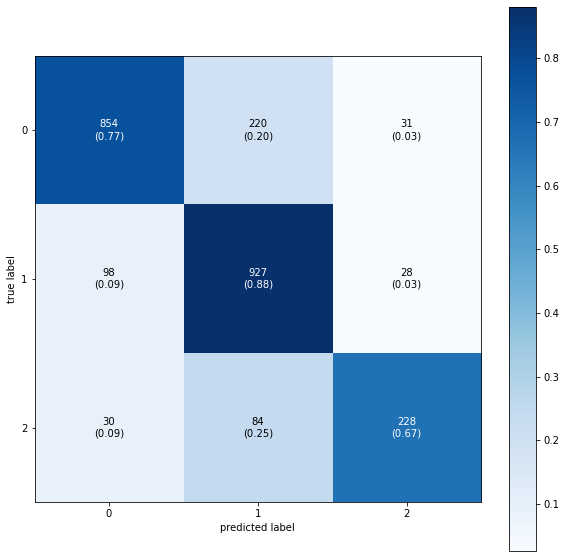

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      1105
     neutral       0.82      0.84      0.83      1053
    positive       0.86      0.67      0.75       342

    accuracy                           0.83      2500
   macro avg       0.84      0.80      0.81      2500
weighted avg       0.83      0.83      0.83      2500

Accuracy score LinearSVC(C=1, max_iter=500)= 0.83


confusion matrix


[[971 120  14]
 [145 884  24]
 [ 35  77 230]]




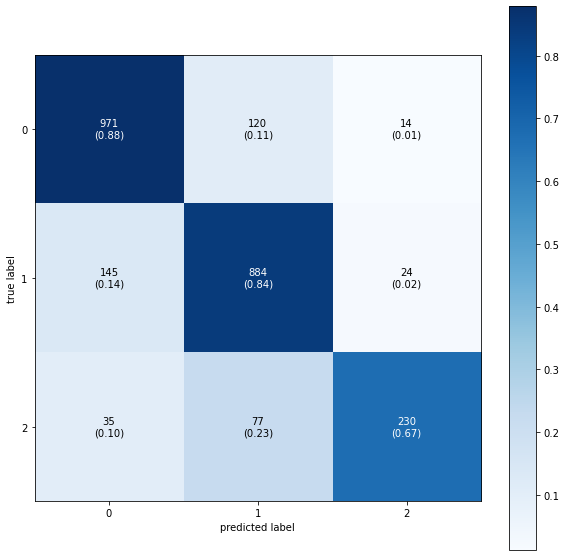

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      1105
     neutral       0.80      0.85      0.82      1053
    positive       0.93      0.58      0.71       342

    accuracy                           0.82      2500
   macro avg       0.85      0.77      0.80      2500
weighted avg       0.83      0.82      0.82      2500

Accuracy score LogisticRegression(C=2)= 0.82


confusion matrix


[[965 131   9]
 [153 893   7]
 [ 48  95 199]]




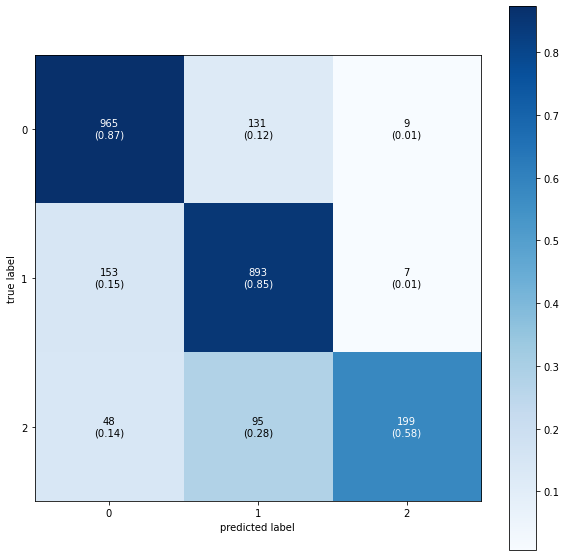

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      1105
     neutral       0.81      0.85      0.83      1053
    positive       0.94      0.57      0.71       342

    accuracy                           0.82      2500
   macro avg       0.86      0.77      0.79      2500
weighted avg       0.83      0.82      0.82      2500

Accuracy score VotingClassifier(estimators=[('SVC', LinearSVC(C=1, max_iter=500)),
                             ('NB', MultinomialNB()),
                             ('Log', LogisticRegression(C=2)),
                             ('raf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_jobs=6,
                                                     random_state=0))])= 0.82


confusion matrix


[[978 119   8]
 [158 890   5]
 [ 56  92 194]]




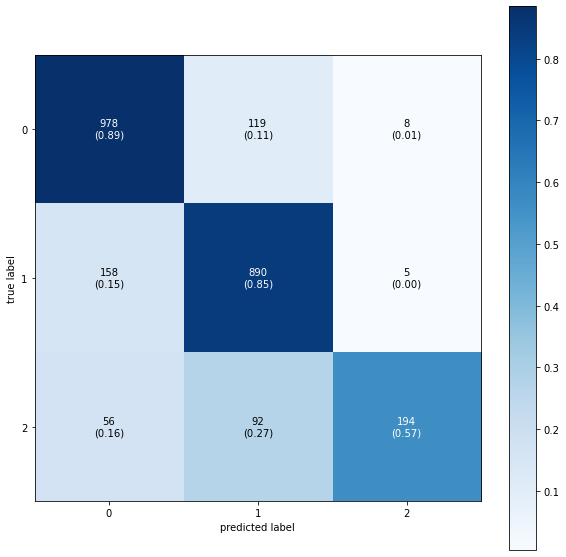

+------------------------------+----------+
|            Model             | Accuracy |
+------------------------------+----------+
|        SVC Algorithm         |   0.83   |
|    Naive Bayes Algorithm     |   0.77   |
| LogisticRegression Algorithm |   0.82   |
|   Random Forest Algorithm    |   0.8    |
|      Ensemble Modelling      |   0.82   |
|        SVC Algorithm         |   0.83   |
|    Naive Bayes Algorithm     |   0.77   |
| LogisticRegression Algorithm |   0.82   |
|   Random Forest Algorithm    |   0.8    |
|      Ensemble Modelling      |   0.82   |
+------------------------------+----------+




In [10]:

def get_prediction(model,X_test, y_test):
    y_test_pred = model.predict(X_test)
    
    print('Test Prediction')
    print('--------------------')
    print(classification_report(y_test, y_test_pred))
    
    return y_test_pred

def conf_mat(y_test,y_pred1):
    print('\n')
    print("confusion matrix")
    print('\n')
    CR=confusion_matrix(y_test, y_pred1)
    print(CR)
    print('\n')

    fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    plt.show()
    
def get_accuracy(model,ypred1):
    y_pred1 = model.predict(X_test_vec)
    print('Accuracy score '+ str(model) +'= {:.2f}'.format(model.score(X_test_vec, y_test)))

# Simple Naive Bayes classifer 
clf1_NB = MultinomialNB()
clf1_NB.fit(X_train_vec, y_train)
nb=clf1_NB.score(X_test_vec, y_test)
_ = get_prediction(clf1_NB, X_test_vec, y_test)

y_pred1 = clf1_NB.predict(X_test_vec)
get_accuracy(clf1_NB,y_pred1)
conf_mat(y_test, y_pred1)

# Instantiate a Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6, class_weight='balanced')
clf_rf.fit(X_train_vec, y_train)
rf=clf_rf.score(X_test_vec, y_test)
_ = get_prediction(clf_rf, X_test_vec, y_test)

y_pred1 = clf_rf.predict(X_test_vec)
get_accuracy(clf_rf,y_pred1)
conf_mat(y_test, y_pred1)

# Instantiate a Linear SVC
svc=LinearSVC(C=1, max_iter=500)
svc= svc.fit(X_train_vec , y_train)
dm=svc.score(X_test_vec, y_test)

_ = get_prediction(svc, X_test_vec, y_test)

y_pred1 = svc.predict(X_test_vec)
get_accuracy(svc,y_pred1)
conf_mat(y_test, y_pred1)

# pip install prettytable

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import prettytable

lor=LogisticRegression(C=2, max_iter=100)
lor= lor.fit(X_train_vec , y_train)
lr=lor.score(X_test_vec, y_test)

_ = get_prediction(lor, X_test_vec, y_test)

y_pred1 = lor.predict(X_test_vec)
get_accuracy(lor,y_pred1)
conf_mat(y_test, y_pred1)

# y_pred1 = lor.predict(X_test_vec)
# lr=lor.score(X_test_vec, y_test)
# print('Accuracy score= {:.2f}'.format(lor.score(X_test_vec, y_test)))


# print('\n')
# print("Precision, Recall, F1")
# print('\n')
# CR=classification_report(y_test, y_pred1)
# print(CR)
# print('\n')


# print('\n')
# print("confusion matrix")
# print('\n')
# CR=confusion_matrix(y_test, y_pred1)
# print(CR)
# print('\n')

# fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
#                                 show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True)
# plt.show()

from sklearn.ensemble import VotingClassifier
Ens = VotingClassifier( estimators= [('SVC',svc),('NB',clf1_NB),('Log',lor),('raf',clf_rf)], voting = 'hard')
Ens= Ens.fit(X_train_vec , y_train)
en=Ens.score(X_test_vec, y_test)

_ = get_prediction(Ens, X_test_vec, y_test)

y_pred1 = Ens.predict(X_test_vec)
get_accuracy(Ens,y_pred1)
conf_mat(y_test, y_pred1)

x.add_row(["SVC Algorithm", round(dm,2)])
x.add_row(["Naive Bayes Algorithm", round(nb,2)])
x.add_row(["LogisticRegression Algorithm", round(lr,2)])
x.add_row(["Random Forest Algorithm", round(rf,2)])
x.add_row(["Ensemble Modelling", round(en,2)])

print(x)
print('\n')


# _, _ = get_prediction(clf_rf, X_train_vec, X_val_vec, y_train, y_val)

# y_pred1 = raf.predict(X_test_vec)
# rf=raf.score(X_test_vec, y_test)
# print('Accuracy score= {:.2f}'.format(raf.score(X_test_vec, y_test)))


# print('\n')
# print("Precision, Recall, F1")
# print('\n')
# CR=classification_report(y_test, y_pred1)
# print(CR)
# print('\n')


# print('\n')
# print("confusion matrix")
# print('\n')
# CR=confusion_matrix(y_test, y_pred1)
# print(CR)
# print('\n')

# fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
#                                 show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True)
# plt.show()




# random_search = RandomizedSearchCV(LinearSVC(random_state=0), 
# { "C": uniform(1, 10)}
# ,cv=5, scoring="r2",verbose=1,n_jobs=-1, n_iter=50, random_state = 0 ) 
# random_search.fit(X_train_vec,y_train)
# # random_search.score(X_train,y_train)

# random_search = RandomizedSearchCV(RandomForestRegressor(random_state=0), 
# { 'n_estimators':np.arange(5,100,5), 'max_features':np.arange(0.1,1.0,0.05), }
# ,cv=5, scoring="r2",verbose=1,n_jobs=-1, n_iter=50, random_state = 0 ) 
# random_search.fit(X_train_vec,y_train)




In [ ]:
########## LSTM model ############

# pip install chart-studio
# pip install cufflinks

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tweets_df['Tweets_Clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(tweets_df['Tweets_Clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(tweets_df['Sentiment_Label']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
########## BERT model ############


# pip install torch
# pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

tweets_df['Tweets_Clean']
tweets_df['Sentiment_Label'].value_counts()
possible_labels = tweets_df.Sentiment_Label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict
tweets_df['Tweets_Clean']

tweets_df['label'] = tweets_df.Sentiment_Label.replace(label_dict)
tweets_df

from sklearn.model_selection import train_test_split

X = tweets_df['Tweets_Clean'] 
y = tweets_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,
                                                    random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

X_train.values

encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest', 
    truncation=True,
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_test.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest', 
    truncation=True,
    max_length=256, 
    return_tensors='pt'
)

import numpy as np
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n'
              
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [ ]:
########## BERT model ############

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
print(_, predictions, true_vals)
accuracy_per_class(predictions, true_vals)

In [3]:
# pip install xgboost
# pip install lightgbm

import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

xgb_mod = xgb.XGBClassifier(objective='multi:softprob', random_state=1)

xgb_mod= xgb_mod.fit(X_train_vec , y_train)

# _ = get_prediction(xgb, X_test_vec, y_test)

# y_pred1 = xgb.predict(X_test_vec)
# get_accuracy(xgb,y_pred1)
# conf_mat(y_test, y_pred1)

# from sklearn.linear_model import LogisticRegressionCV
# logist = clf = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300).fit(X_train_vec, y_train)
# saved_clf.score(X_test_vec, y_test)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:08:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
# pip install pycocotools
# pip install mlxtend

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

# X_vec = tfidf_vectorizer.fit_transform(X).toarray()

# scores = cross_val_score(svc, X_vec, y, cv=5, scoring='accuracy')
# print(scores.mean())


# C_range=list(range(1,5))
# acc_score=[]
# for c in C_range:
#     svc = LinearSVC(dual=False, C=c)
#     scores = cross_val_score(svc, X_vec, y, cv=5, scoring='accuracy')
#     acc_score.append(scores.mean())
    
# C_values=list(range(1,5))
# fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
# fig.update_layout(xaxis_title='Value of C for SVC',
#                    yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
# fig.show()

# C_range=list(np.arange(0.1,6,0.1))
# acc_score=[]
# for c in C_range:
#     svc = LinearSVC(dual=False, C=c)
#     scores = cross_val_score(svc, X_vec, y, cv=5, scoring='accuracy')
#     acc_score.append(scores.mean())
    
# C_values=list(np.arange(0.1,6,0.1))
# fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
# fig.update_layout(xaxis_title='Value of C for SVC',
#                    yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
# fig.show()

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from IPython.core.interactiveshell import InteractiveShell
from sklearn.naive_bayes import MultinomialNB
InteractiveShell.ast_node_interactivity = "all"


df_scores = pd.DataFrame(columns=['Trainset Accuracy', 'CV Accuracy', 
                                  'Testset Accuracy', 'Testset Logloss'])
df_scores.index.name = "Model"

# individual models

m_log = LogisticRegression(C=0.8, class_weight=0.5, max_iter=2000, random_state=42)

m_dec = DecisionTreeClassifier(max_depth=4, 
                               min_samples_split=75, 
                               min_samples_leaf=5, random_state=42)


xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, seed=42,
                            base_score=0.5, booster='gbtree', colsample_bylevel=1,
                            colsample_bynode=1, colsample_bytree=1, gamma=0,
                            learning_rate=0.1, max_delta_step=0, max_depth=2,
                            n_jobs=-1, reg_alpha=0, reg_lambda=1, subsample=0.7)



models = [m_log, m_dec, forest, xgb_clf]

functions = [model_runner_log, model_runner_dec, 
             model_runner_forest, model_runner_xgb]

for m, f in zip(models, functions):
    train_accuracy, cv_accuracy, test_accuracy, test_logloss, model_name = f(m, X_train, X_test, y_train, y_test)
    df_scores.at["{a}".format(a=model_name)] = [train_accuracy, cv_accuracy, test_accuracy, test_logloss]
    plot_confusion_matrix(m, X_test, y_test, normalize= 'true')
    plt.title('Fake News Confusion Matrix {a}'.format(a=model_name), fontsize=10, pad=10)
    plt.savefig('Fake News Confusion Matrix {a}.png'.format(a=model_name), format='png', dpi=1000);

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      1105
     neutral       0.80      0.85      0.82      1053
    positive       0.93      0.58      0.71       342

    accuracy                           0.82      2500
   macro avg       0.85      0.77      0.80      2500
weighted avg       0.83      0.82      0.82      2500

Accuracy score LogisticRegression(C=2)= 0.82


confusion matrix


[[965 131   9]
 [153 893   7]
 [ 48  95 199]]




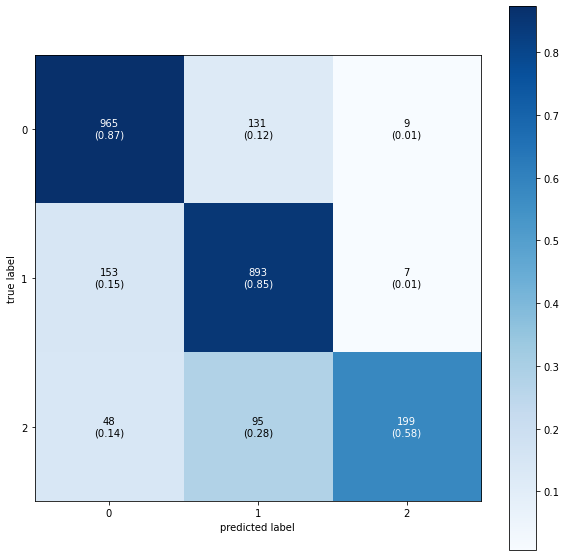

Accuracy score= 0.82


Precision, Recall, F1


              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      1105
     neutral       0.81      0.85      0.83      1053
    positive       0.94      0.57      0.71       342

    accuracy                           0.82      2500
   macro avg       0.86      0.77      0.79      2500
weighted avg       0.83      0.82      0.82      2500





confusion matrix


[[978 119   8]
 [158 890   5]
 [ 56  92 194]]




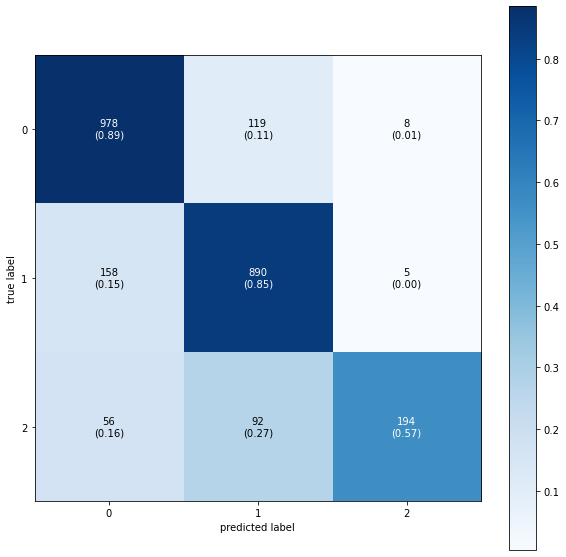



Comparison of all algorithm results
+------------------------------+----------+
|            Model             | Accuracy |
+------------------------------+----------+
|        SVC Algorithm         |   0.83   |
|    Naive Bayes Algorithm     |   0.77   |
| LogisticRegression Algorithm |   0.82   |
|   Random Forest Algorithm    |   0.8    |
|      Ensemble Modelling      |   0.82   |
+------------------------------+----------+


